# Overview
The purpose of this notebook is to build a model to predict whether or not a user of Ultimate Technologies's ride hailing app will be active in their 6th month on the system. This model and insights dervied from it will then be reported to the company in an accompanying report. 

# Code Navigation 

* [1. Load Libraries & Data](#1.LoadLibraries&Data)
* [2. Data Cleaning](#2.DataCleaning)
* [3. Exploratory Data Analysis](#3.ExploratoryDataAnalysis)
* [4. Preprocessing](#4.Preprocessing)
* [5. Model Training & Evaluation](#5.ModelTraining&Evaluation)
    * [5.1. Logistic Regression](#5.1.LogisticRegression)
    * [5.2. Gradient Boosting](#5.2.GradientBoosting)
    * [5.3. Random Forest](#5.3.RandomForest)

## 1. Load Libraries & Data <a class="anchor" id="1.LoadLibraries&Data"></a>

In [1]:
#General imports & notebook configuration 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams.update({'font.size': 15})

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%load_ext autoreload

#Change directory to project root directory
os.chdir("..")

In [2]:
#Custom function imports
from src.data.PlotFeatureImportance import Plot_Feat_Imp
from src.data.plotPrecisionRecall_ import Plot_PR
from src.models.Parameter_Search import parameter_search
from src.data.Log_Transform import log_trans_columns

In [3]:
#Sklearn imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC  
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, classification_report, \
roc_curve, plot_precision_recall_curve, precision_recall_curve, confusion_matrix, auc, plot_roc_curve
from sklearn.feature_selection import SelectFromModel

In [4]:
#Read in data 
df=pd.read_json('data/raw/ultimate_data_challenge.json')

#Explore a slice of the data
df.head(5)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


## 2. Data Cleaning <a class="anchor" id="2.DataCleaning"></a>

In [5]:
#Change the variable types of some of the columns
df.last_trip_date=pd.to_datetime(df.last_trip_date)
df.signup_date=pd.to_datetime(df.signup_date)
df.ultimate_black_user=df.ultimate_black_user.astype(int)

In [6]:
#Add column indicating if a customer is active - i.e. took a trip in the last month(that is, the whole month of June & July 1st)
df['active']=np.where((df.last_trip_date.dt.month==6) |(df.last_trip_date.dt.month==7),1,0)
df['active_str']=np.where((df.last_trip_date.dt.month==6) |(df.last_trip_date.dt.month==7),'active','inactive')

In [7]:
#Change datetime columns to 'days since' columns by subtracting the last day in the dataset; drop original columns
#Needed to explore data and to use for modeling with sklearn
last_day=df.last_trip_date.describe()['last']
df['days_since_signup']=[i.days for i in list(last_day-df.signup_date)]
df['days_since_last_trip']=[i.days for i in list(last_day-df.last_trip_date)]
df.drop(columns=['signup_date','last_trip_date'],inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   avg_rating_of_driver    41878 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   phone                   49604 non-null  object 
 5   surge_pct               50000 non-null  float64
 6   ultimate_black_user     50000 non-null  int32  
 7   weekday_pct             50000 non-null  float64
 8   avg_dist                50000 non-null  float64
 9   avg_rating_by_driver    49799 non-null  float64
 10  active                  50000 non-null  int32  
 11  active_str              50000 non-null  object 
 12  days_since_signup       50000 non-null  int64  
 13  days_since_last_trip    50000 non-null  int64  
dtypes: float64(6), int32(2), int64(3), obj

In [8]:
#The entries missing phone data are relatively few; will drop these rows
df.dropna(subset=['phone'],inplace=True)

#Fill in missing values for rating with mean value
df['avg_rating_of_driver']=df['avg_rating_of_driver'].fillna(value=df['avg_rating_of_driver'].median())
df['avg_rating_by_driver']=df['avg_rating_by_driver'].fillna(value=df['avg_rating_by_driver'].median())
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   avg_rating_of_driver    49604 non-null  float64
 3   avg_surge               49604 non-null  float64
 4   phone                   49604 non-null  object 
 5   surge_pct               49604 non-null  float64
 6   ultimate_black_user     49604 non-null  int32  
 7   weekday_pct             49604 non-null  float64
 8   avg_dist                49604 non-null  float64
 9   avg_rating_by_driver    49604 non-null  float64
 10  active                  49604 non-null  int32  
 11  active_str              49604 non-null  object 
 12  days_since_signup       49604 non-null  int64  
 13  days_since_last_trip    49604 non-null  int64  
dtypes: float64(6), int32(2), int64(3), obj

In [9]:
#Check the ranges of numeric features for outliers
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,days_since_signup,days_since_last_trip
count,49604.000000,49604.00000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000
mean,2.277256,4.64977,1.074991,8.875314,0.375212,60.883832,5.785418,4.778748,0.376401,165.456657,72.532155
std,3.793300,0.57582,0.222666,19.989018,0.484182,37.086239,5.669709,0.446440,0.484487,8.754524,61.656616
min,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,151.000000,0.000000
25%,0.000000,4.50000,1.000000,0.000000,0.000000,33.300000,2.420000,4.700000,0.000000,158.000000,13.000000
50%,1.000000,4.90000,1.000000,0.000000,0.000000,66.700000,3.880000,5.000000,0.000000,165.000000,54.000000
75%,3.000000,5.00000,1.050000,8.700000,1.000000,100.000000,6.930000,5.000000,1.000000,173.000000,136.250000
max,125.000000,5.00000,8.000000,100.000000,1.000000,100.000000,160.960000,5.000000,1.000000,181.000000,181.000000


In [10]:
#Indeed there is. Will replace with the next highest value. 
df.loc[df.avg_dist>100,'avg_dist']=79.69

In [11]:
#Do the same with trips_in_first_30_days
df.trips_in_first_30_days.sort_values(ascending=False)[0:10]

18514    125
99        73
3030      71
29070     63
48804     58
36917     56
45489     56
17942     55
29043     55
33488     54
Name: trips_in_first_30_days, dtype: int64

In [12]:
#One major outlier; will replace with next highest value
df.loc[df.trips_in_first_30_days>100,'trips_in_first_30_days']=73

In [13]:
#Finally will check average surge
df.avg_surge.sort_values(ascending=False)[0:10]

13861    8.00
30477    5.75
49383    5.00
21894    5.00
2817     5.00
19191    5.00
47052    5.00
1405     4.75
10546    4.50
33628    4.50
Name: avg_surge, dtype: float64

In [14]:
#One major outlier; will replace with next highest value
df.loc[df.avg_surge>6,'avg_surge']=5.75

## 3. Exploratory Data Analysis <a class="anchor" id="3.ExploratoryDataAnalysis"></a>

In [15]:
#Determine number of active vs. inactive accounts
print(round((df.active_str.value_counts()['active']/len(df))*100,2),'% of users in this cohort are active')
print(round((df.active_str.value_counts()['inactive']/len(df))*100,2), '% of users in this cohort are inactive')

37.64 % of users in this cohort are active
62.36 % of users in this cohort are inactive


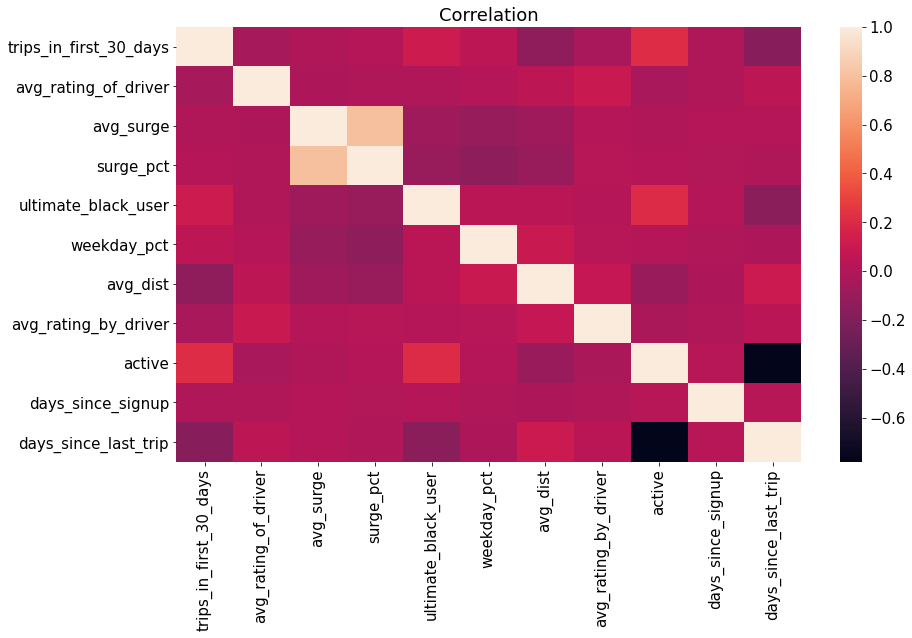

In [16]:
#Plot the correlation of the (mostly) absolute count features
plt.subplots(figsize=(14,8))
sns.heatmap(df.corr())
plt.title('Correlation')
plt.show()

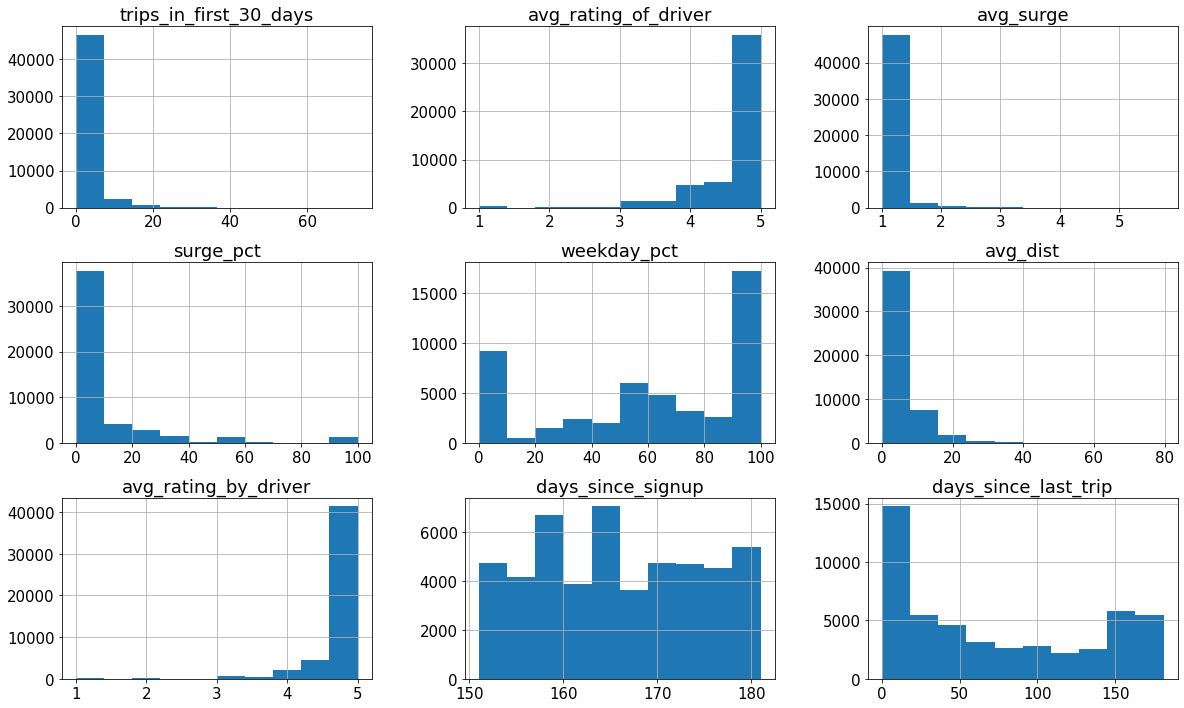

In [17]:
#Obtain a dataframe of only the numerical features
df_numerical=df[['trips_in_first_30_days','avg_rating_of_driver',
                   'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist',
                   'avg_rating_by_driver','days_since_signup','days_since_last_trip']]

#Plot a histogram of all features
df_numerical.hist(figsize=(20,12))
plt.show()

In [18]:
#Calculate summary statistics based on different groups 

#Melt the df so that all lab values are stacked in the same column, create new cummulative 'Value' column
df_orig_melted=pd.melt(pd.concat([df_numerical,df.active_str],axis=1),id_vars='active_str',var_name='Feature_Name',value_name='Value')
#Calculate summary statistics for each combination of lab value and sepsis group
func={'Value':['max','min','median','mean','std']}
df_orig_melted.groupby(['Feature_Name','active_str']).aggregate(func)

Value                             \
                                      max    min  median        mean   
Feature_Name           active_str                                      
avg_dist               active       79.69    0.0    3.73    5.109577   
                       inactive     79.69    0.0    4.03    6.190725   
avg_rating_by_driver   active        5.00    1.0    4.80    4.763167   
                       inactive      5.00    1.0    5.00    4.788152   
avg_rating_of_driver   active        5.00    1.0    4.90    4.619704   
                       inactive      5.00    1.0    4.90    4.667918   
avg_surge              active        4.50    1.0    1.00    1.073834   
                       inactive      5.75    1.0    1.00    1.075616   
days_since_last_trip   active       30.00    0.0    9.00   10.597076   
                       inactive    181.00   31.0  114.00  109.915850   
days_since_signup      active      181.00  151.0  165.00  165.686144   
                       inactive    181.00  151.0  165.00  165.318139   
surge_pct              active      100.00    0.0    0.00    9.165615   
                       inactive    100.00    0.0    0.00    8.700091   
trips_in_first_30_days active       73.00    0.0    2.00    3.302019   
                       inactive     73.00    0.0    1.00    1.657033   
weekday_pct            active      100.00    0.0   64.30   61.344208   
                       inactive    100.00    0.0   69.20   60.605952   

                                              
                                         std  
Feature_Name           active_str             
avg_dist               active       4.507865  
                       inactive     6.184010  
avg_rating_by_driver   active       0.328871  
                       inactive     0.504082  
avg_rating_of_driver   active       0.525777  
                       inactive     0.603307  
avg_surge              active       0.162905  
                       inactive     0.250289  
days_since_last_trip   active       8.668302  
                       inactive    48.351067  
days_since_signup      active       8.877633  
                       inactive     8.676578  
surge_pct              active      15.599652  
                       inactive    22.221133  
trips_in_first_30_days active       4.931300  
                       inactive     2.655767  
weekday_pct            active      29.512875  
                       inactive    40.983689

In [19]:
#Normalize all numerical values for violin plot
df_numerical_std=(df_numerical-df_numerical.min())/(df_numerical.max()-df_numerical.min())

#Retrieve the active account column
df_numerical_std=pd.concat([df_numerical_std,df.active_str],axis=1)

#Print a slice of new dataframe 
df_numerical_std.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,days_since_signup,days_since_last_trip,active_str
0,0.054795,0.925,0.021053,0.154,0.462,0.046053,1.000,0.200000,0.077348,active
1,0.000000,1.000,0.000000,0.000,0.500,0.103652,1.000,0.066667,0.314917,inactive
2,0.041096,0.825,0.000000,0.000,1.000,0.009662,1.000,0.833333,0.966851,inactive
3,0.123288,0.900,0.029474,0.200,0.800,0.029615,0.975,0.700000,0.011050,active
4,0.191781,0.850,0.040000,0.118,0.824,0.039277,0.975,0.133333,0.596685,inactive


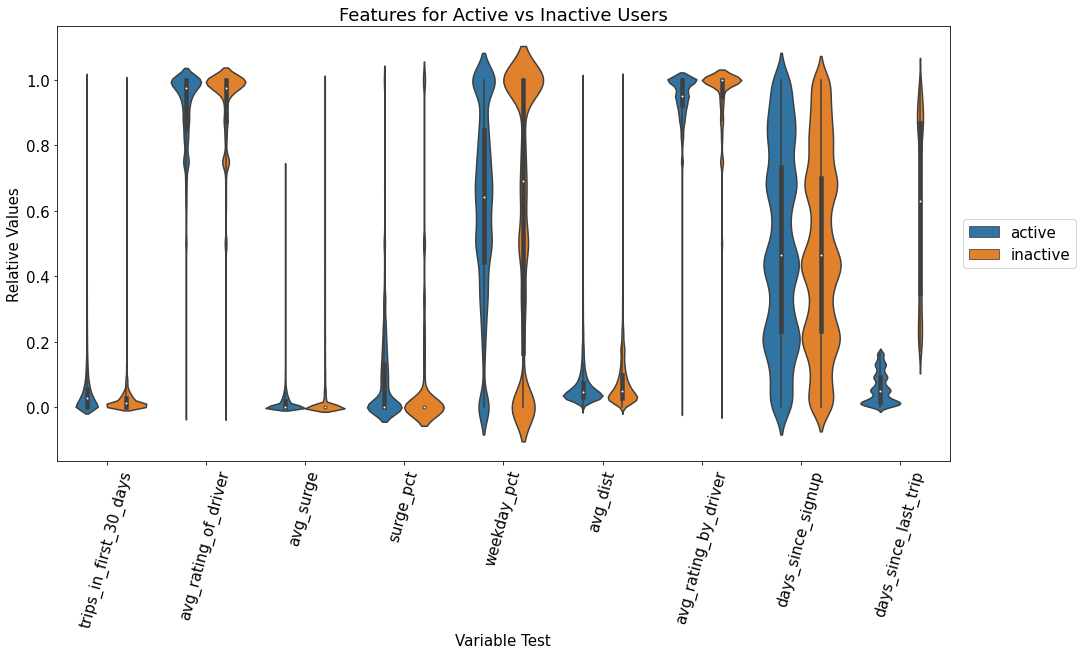

In [20]:
#Melt the dataframe 
df_melted=pd.melt(df_numerical_std,id_vars='active_str')

#Plot the distributions with boxplots
plt.subplots(figsize=(16,8))
sns.violinplot(x='variable',y='value',hue='active_str',data=df_melted,showfliers = True)
plt.xticks(rotation=75)
plt.ylabel('Relative Values')
plt.xlabel('Variable Test')
plt.title('Features for Active vs Inactive Users')
plt.legend(loc='center right', bbox_to_anchor=(1.15, 0.5), ncol=1)
plt.show()

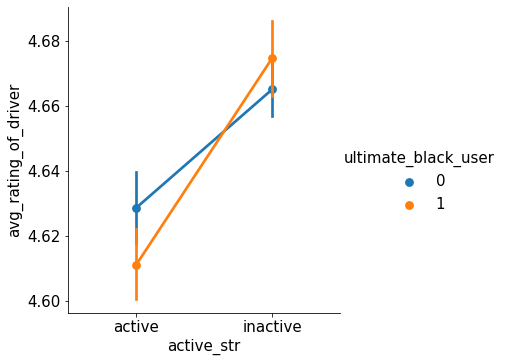

In [21]:
sns.catplot(x='active_str',y='avg_rating_of_driver',hue='ultimate_black_user',data=df,estimator=np.mean,kind='point')
plt.show()

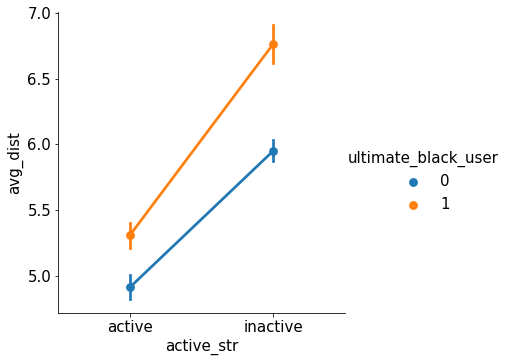

In [22]:
sns.catplot(x='active_str',y='avg_dist',hue='ultimate_black_user',data=df,estimator=np.mean,kind='point')
plt.show()

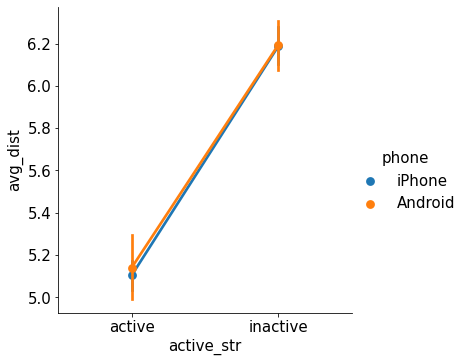

In [23]:
sns.catplot(x='active_str',y='avg_dist',hue='phone',data=df,estimator=np.mean,kind='point')
plt.show()

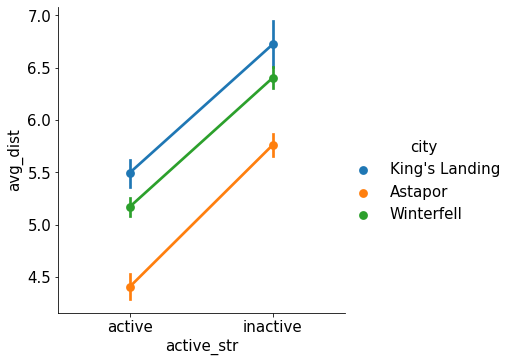

In [24]:
sns.catplot(x='active_str',y='avg_dist',hue='city',data=df,estimator=np.mean,kind='point')
plt.show()

## 4. Preprocessing <a class="anchor" id="4.Preprocessing"></a>

In [25]:
#Since the days since last trip column is used to determine if a user is active or not, including it in the model
#would be data leakage. It cannot be used as an explanatory feature and thus must be removed
df.drop(columns='days_since_last_trip',inplace=True)

#Drop redundant active_str column
df.drop(columns='active_str',inplace=True)

#Encode Categorical Variables 
df=pd.get_dummies(df,drop_first=True)

#Explore final dataframe
df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,days_since_signup,city_King's Landing,city_Winterfell,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,157,1,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,153,0,0,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,176,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,172,1,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,155,0,1,0


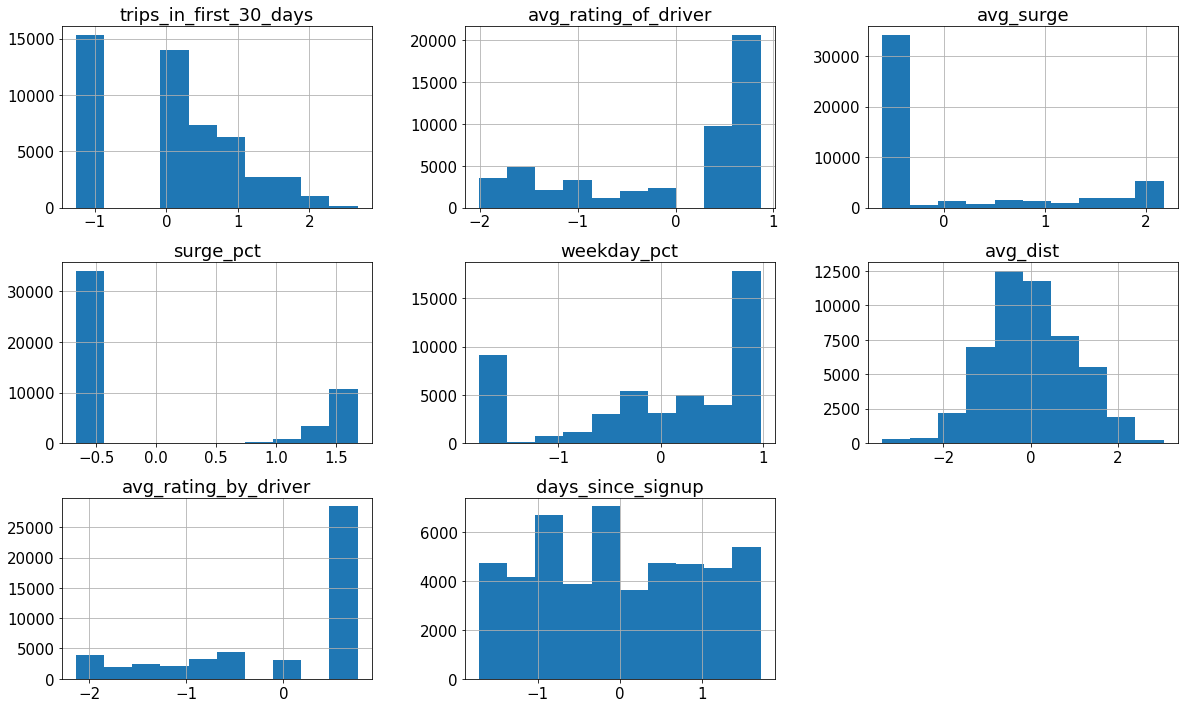

In [26]:
list_=['trips_in_first_30_days','avg_rating_of_driver',
    'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist',
    'avg_rating_by_driver','days_since_signup']

df_log=log_trans_columns(df,list_,PowerTransformer,np)

#Plot a histogram of all features
df_log[list_].hist(figsize=(20,12))
plt.show()

Applying a log transform seems to only convert the average distance variable into a normal distribution. This is not surprising, because most of the other variables have a strict range - i.e. surge & weekday percent are between 0 and 100, and the ratings columns are between 1 and 5. Average surge and trips in first 30 days simply do not have log-normal distributions to begin with. 

Therefore I will not apply a log transform to normalize the variables, just a min/max scaler. I will only use algorithms that can accept non-normally distributed variables - Logistic Regression, Random Forest & Gradient Boosting.

In [27]:
#Split the data into training & testing sets.
X=df.drop(columns='active')
y=df.active
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42,)

#Apply min/max scaler
mm=MinMaxScaler()

#fit on train set only
mm.fit(X_train)

#transform test & train sets 
X_train=mm.transform(X_train)
X_test=mm.transform(X_test)

## 5. Model Training & Evaluation <a class="anchor" id="5.ModelTraining&Evaluation"></a>

### 5.1. Logistic Regression <a class="anchor" id="5.1.LogisticRegression"></a>

In [28]:
#Randomized search for Gradient Boost Classifier
parameters={'C':[1]+[1/(10**i) for i in range(1,5)]}

search_LR, best_dict_LR, LR = parameter_search('LogisticRegression',X_train,y_train,parameters,RandomizedSearchCV,
                                            RandomForestClassifier,GradientBoostingClassifier,LogisticRegression,
                                            'f1',5)

best_dict_LR

{'C': 0.1}

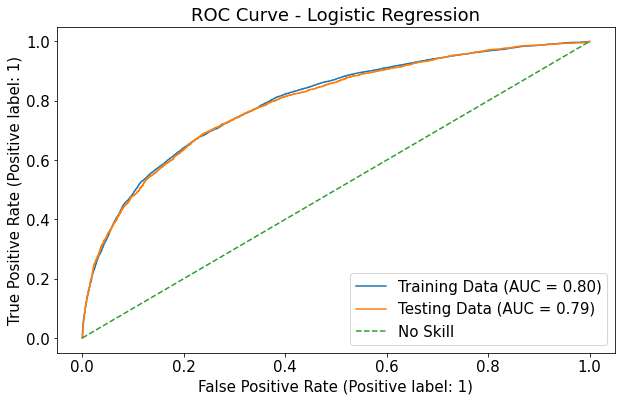

In [29]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(LR,X_train,y_train,ax=_,name='Training Data')
plot_roc_curve(LR,X_test,y_test,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - Logistic Regression')
plt.show()

Best Train Threshold=0.289580, F-Score=0.664
Best Test Threshold=0.378163, F-Score=0.662
Train AUC: 0.718 Test AUC: 0.714


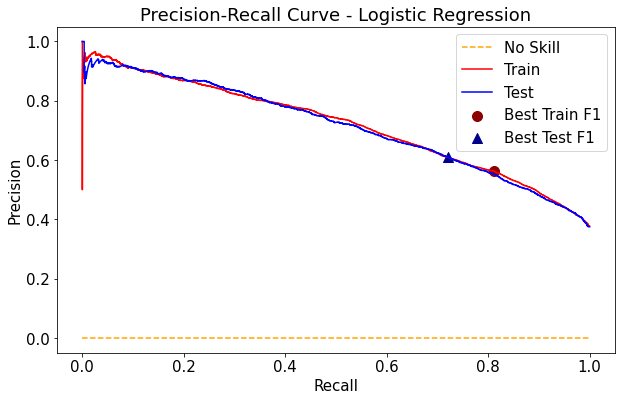

In [30]:
#Plot Precision Recall Curve
title='Precision-Recall Curve - Logistic Regression'
prob=Plot_PR(LR,X_train,y_train,X_test,y_test,title,auc,precision_recall_curve,np,plt,(10,6))

In [31]:
#Print confusion matrix & classficiation report using the probability threshold 
#that yields the best f1 score on the training set
q=LR.predict_proba(X_test)[:,1]
y_pred_test_new=[1 if i>prob else 0 for i in q]
print(classification_report(y_test,y_pred_test_new))
print(confusion_matrix(y_test,y_pred_test_new))

              precision    recall  f1-score   support

           0       0.84      0.60      0.70      7750
           1       0.55      0.81      0.66      4651

    accuracy                           0.68     12401
   macro avg       0.70      0.71      0.68     12401
weighted avg       0.73      0.68      0.69     12401

[[4684 3066]
 [ 875 3776]]


## 5.2. Gradient Boosting <a class="anchor" id="5.2.GradientBoosting"></a>

In [32]:
#Randomized search for Gradient Boost Classifier
parameters={'max_depth': [3,5,7],
            'n_estimators': [100,200,300],
            'learning_rate': [(1/20)*i for i in range(1,6)],
            'max_features': ['sqrt']}

search_GB, best_dict_GB, GB = parameter_search('GradientBoost',X_train,y_train,parameters,RandomizedSearchCV,
                                            RandomForestClassifier,GradientBoostingClassifier,LogisticRegression,
                                            'f1',45)

best_dict_GB

{'n_estimators': 300,
 'max_features': 'sqrt',
 'max_depth': 5,
 'learning_rate': 0.1}

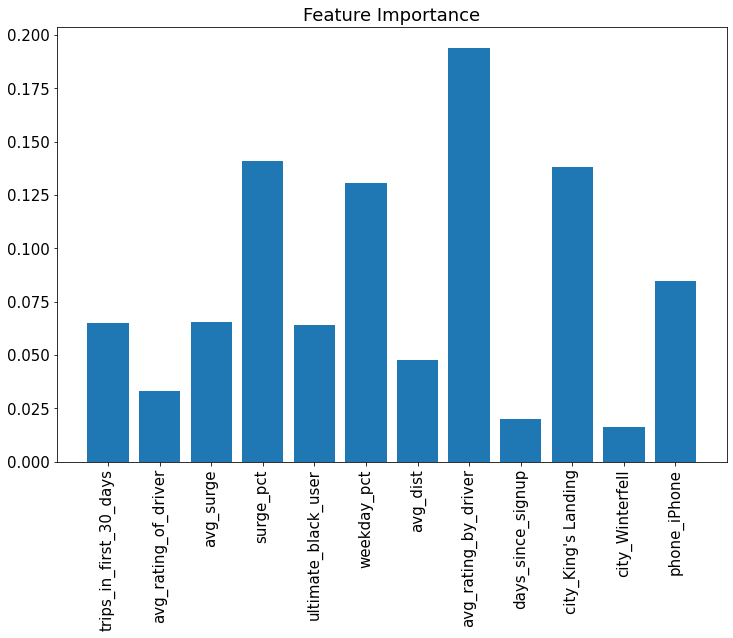

In [33]:
#Plot Feature Importance 
Plot_Feat_Imp(GB,X.columns,pd,np,plt,(12,8))

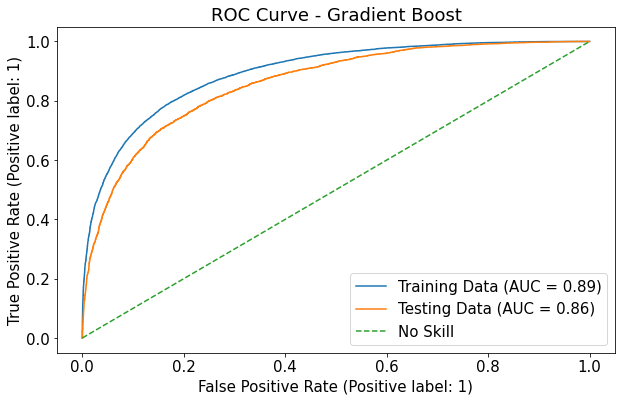

In [34]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(GB,X_train,y_train,ax=_,name='Training Data')
plot_roc_curve(GB,X_test,y_test,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - Gradient Boost')
plt.show()

Best Train Threshold=0.385148, F-Score=0.763
Best Test Threshold=0.354468, F-Score=0.722
Train AUC: 0.848 Test AUC: 0.792


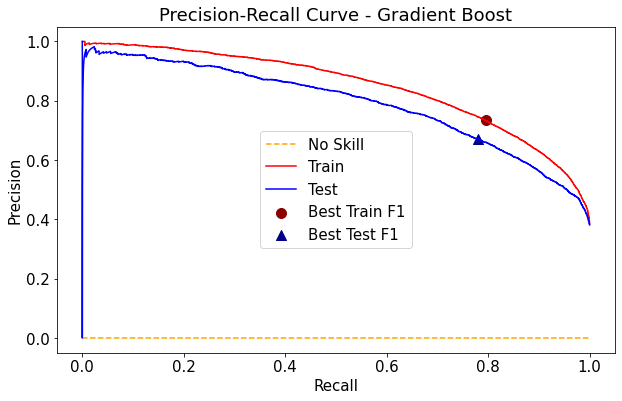

In [35]:
#Plot Precision Recall Curve
title='Precision-Recall Curve - Gradient Boost'
prob=Plot_PR(GB,X_train,y_train,X_test,y_test,title,auc,precision_recall_curve,np,plt,(10,6))

In [36]:
#Print confusion matrix & classficiation report using the probability threshold 
#that yields the best f1 score on the training set
q=GB.predict_proba(X_test)[:,1]
y_pred_test_new=[1 if i>prob else 0 for i in q]
print(classification_report(y_test,y_pred_test_new))
print(confusion_matrix(y_test,y_pred_test_new))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      7750
           1       0.69      0.75      0.72      4651

    accuracy                           0.78     12401
   macro avg       0.77      0.77      0.77     12401
weighted avg       0.79      0.78      0.78     12401

[[6163 1587]
 [1147 3504]]


In [42]:
1-3504/(1147+3504)

0.2466136314771017

In [43]:
1-6163/(6163+1587)

0.2047741935483871

In [38]:
GB.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [47]:
import pickle
with open('GB.pickle','wb') as modelFile:
     pickle.dump(GB,modelFile)

## 5.3. Random Forest <a class="anchor" id="5.3.RandomForest"></a>

In [37]:
parameters={'max_depth': [3,5,7],
            'n_estimators': [100,200,300],
            'max_depth': [x**2 for x in range(2,10)],
            'min_samples_split': [4,7,16],
            'min_samples_leaf':[4,7,16],
            'max_features':['sqrt']}

search_RFC, best_dict_RFC, RFC = parameter_search('RandomForest',X_train,y_train,parameters,RandomizedSearchCV,
                                            RandomForestClassifier,GradientBoostingClassifier,LogisticRegression,
                                            'f1',40)
best_dict_RFC

{'n_estimators': 300,
 'min_samples_split': 7,
 'min_samples_leaf': 7,
 'max_features': 'sqrt',
 'max_depth': 64}

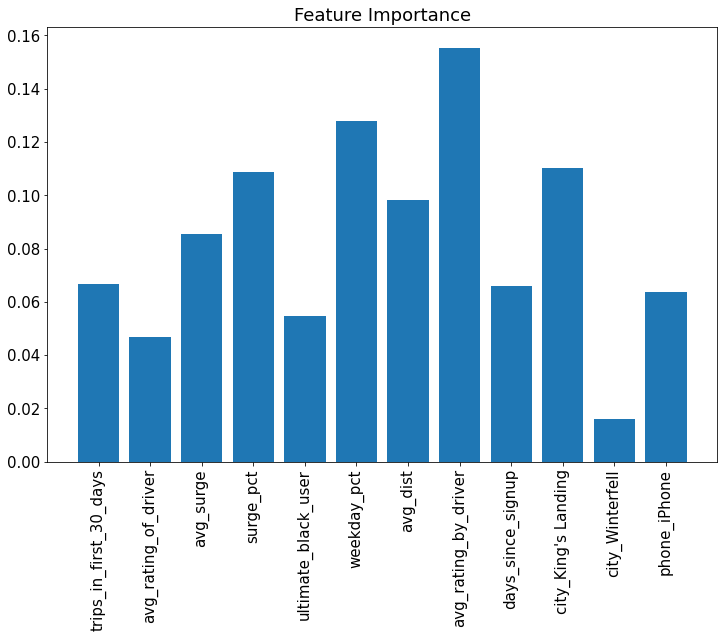

In [38]:
#Plot Feature Importance 
Plot_Feat_Imp(RFC,X.columns,pd,np,plt,(12,8))

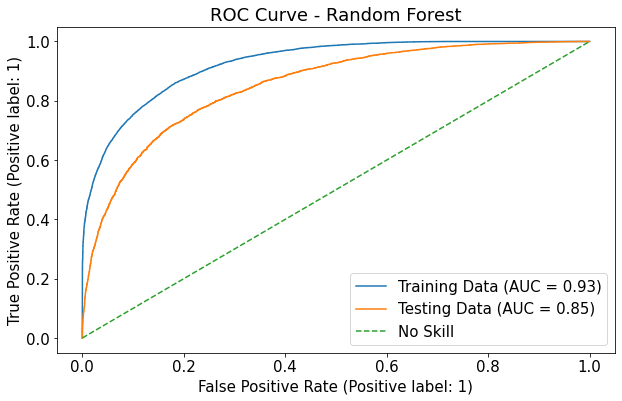

In [39]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(RFC,X_train,y_train,ax=_,name='Training Data')
plot_roc_curve(RFC,X_test,y_test,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - Random Forest')
plt.show()

Best Train Threshold=0.365911, F-Score=0.795
Best Test Threshold=0.382158, F-Score=0.716
Train AUC: 0.894 Test AUC: 0.784


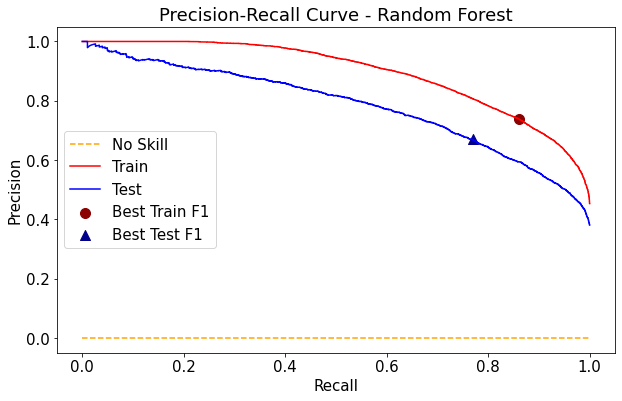

In [40]:
#Plot Precision Recall Curve
title='Precision-Recall Curve - Random Forest'
prob=Plot_PR(RFC,X_train,y_train,X_test,y_test,title,auc,precision_recall_curve,np,plt,(10,6))

In [41]:
#Print confusion matrix & classficiation report using the probability threshold 
#that yields the best f1 score on the training set
q=RFC.predict_proba(X_test)[:,1]
y_pred_test_new=[1 if i>prob else 0 for i in q]
print(classification_report(y_test,y_pred_test_new))
print(confusion_matrix(y_test,y_pred_test_new))

              precision    recall  f1-score   support

           0       0.85      0.75      0.80      7750
           1       0.66      0.78      0.71      4651

    accuracy                           0.76     12401
   macro avg       0.75      0.77      0.76     12401
weighted avg       0.78      0.76      0.77     12401

[[5847 1903]
 [1014 3637]]
